#### SAM2AutomaticMaskGenerator 可选参数

```py
    mask_generator_0 = SAM2AutomaticMaskGenerator(
        model=sam2,  # 预训练的 SAM2 模型实例
        points_per_side=64,  # 每边采样点数：在图像每边生成 64 个提示点
        points_per_batch=128, # 批处理大小：每次处理 128 个点, 用于控制内存使用和计算效率
        pred_iou_thresh=0.7, # IoU 阈值：预测的 IoU 分数必须 ≥ 0.7, 用于过滤低质量的掩码预测
        stability_score_thresh=0.92, # 稳定性分数阈值：≥ 0.92 才保留, 衡量掩码在不同扰动下的稳定性
        stability_score_offset=0.7, # 稳定性计算偏移量, 用于计算稳定性分数的参数
        crop_n_layers=1, # 裁剪层数：对图像进行 1 层多尺度裁剪; 0 = 不裁剪，1 = 裁剪成 4 块，2 = 裁剪成 16 块
        crop_n_points_downscale_factor=2, # 裁剪时点数缩放因子, 裁剪后的图像块使用 points_per_side/2 个点
        box_nms_thresh=0.7, # 边界框 NMS 阈值：IoU > 0.7 的重叠框会被抑制, 用于去除重复的掩码
        min_mask_region_area=25.0, # 最小掩码区域面积：< 25 像素的掩码会被过滤, 去除过小的噪声区域
        use_m2m=True, # 启用 Mask-to-Mask 精化：使用掩码间的关系进行优化, 提高分割质量
    )
```

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import cv2

class SAM2Comparator:
    """SAM2 和 SAM2.1 模型对比器"""

    def __init__(self,
                sam2_checkpoint="./models/sam2/sam2_hiera_base_plus.pt",
                sam2_1_checkpoint="./models/sam2/sam2.1_hiera_base_plus.pt",
                model_cfg_0="configs/sam2/sam2_hiera_b+.yaml",
                model_cfg_1="configs/sam2.1/sam2.1_hiera_b+.yaml",
                device="cuda"):
        """
        Args:
            sam2_checkpoint: SAM2 模型权重路径
            sam2_1_checkpoint: SAM2.1 模型权重路径
            model_cfg_0: SAM2 配置文件路径
            model_cfg_1: SAM2.1 配置文件路径
            device: 计算设备
        """
        self.device = torch.device(device)

        self.sam2 = build_sam2(model_cfg_0, sam2_checkpoint,
                            device=self.device, apply_postprocessing=False)

        self.sam2_1 = build_sam2(model_cfg_1, sam2_1_checkpoint,
                            device=self.device, apply_postprocessing=False)

        self.mask_generator_0 = SAM2AutomaticMaskGenerator(
            model=self.sam2,
            use_m2m=True,
            min_mask_region_area=300.0,
            points_per_side=8
        )
        self.mask_generator_1 = SAM2AutomaticMaskGenerator(
            model=self.sam2_1,
            use_m2m=True,
            min_mask_region_area=300.0,
            points_per_side=8
        )

    # def show_anns(self, anns, borders=True):
    #     """
    #     Args:
    #         anns: 掩码注释列表
    #         borders: 是否显示边界
    #     """
    #     if len(anns) == 0:
    #         return

    #     sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    #     ax = plt.gca()
    #     ax.set_autoscale_on(False)

    #     img = np.ones((sorted_anns[0]['segmentation'].shape[0],
    #                 sorted_anns[0]['segmentation'].shape[1], 4))
    #     img[:, :, 3] = 0

    #     for ann in sorted_anns:
    #         m = ann['segmentation']
    #         color_mask = np.concatenate([np.random.random(3), [0.5]])
    #         img[m] = color_mask

    #         if borders:
    #             contours, _ = cv2.findContours(m.astype(np.uint8),
    #                                         cv2.RETR_EXTERNAL,
    #                                         cv2.CHAIN_APPROX_NONE)
    #             contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True)
    #                     for contour in contours]
    #             cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    #     ax.imshow(img)

    def show_anns(self, anns, borders=True, show_labels=True):
        """
        Args:
            anns: 掩码注释列表
            borders: 是否显示边界
            show_labels: 是否在掩码中心显示标号
        """
        if len(anns) == 0:
            return

        sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
        ax = plt.gca()
        ax.set_autoscale_on(False)

        img = np.ones((sorted_anns[0]['segmentation'].shape[0],
                    sorted_anns[0]['segmentation'].shape[1], 4))
        img[:, :, 3] = 0

        for idx, ann in enumerate(sorted_anns):
            m = ann['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.5]])
            img[m] = color_mask

            if borders:
                contours, _ = cv2.findContours(m.astype(np.uint8),
                                            cv2.RETR_EXTERNAL,
                                            cv2.CHAIN_APPROX_NONE)
                contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True)
                        for contour in contours]
                cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

            # 在掩码中心添加标号
            if show_labels:
                # 计算掩码的中心点
                y_coords, x_coords = np.where(m)
                if len(y_coords) > 0 and len(x_coords) > 0:
                    center_y = int(np.mean(y_coords))
                    center_x = int(np.mean(x_coords))

                    # 添加文本标号
                    ax.text(center_x, center_y, str(idx),
                        fontsize=12, fontweight='bold',
                        color='white', ha='center', va='center',
                        bbox=dict(boxstyle='round,pad=0.3',
                                    facecolor='black', alpha=0.7))

        ax.imshow(img)


    def compare_models(self, image_path, figsize=(24, 8), random_seed=3):
        """
        Args:
            image_path: 图像路径或 PIL Image 对象
            figsize: 图像尺寸
            save_path: 保存路径（可选）
            random_seed: 随机种子
        Returns:
            masks_sam2, masks_sam2_1: 两个模型的掩码结果
        """
        if isinstance(image_path, str):
            image = Image.open(image_path)
        else:
            image = image_path
        image = np.array(image.convert("RGB"))

        masks_sam2 = self.mask_generator_0.generate(image)
        masks_sam2_1 = self.mask_generator_1.generate(image)

        # 设置随机种子确保颜色一致性
        np.random.seed(random_seed)
        # 创建三图对比可视化
        fig, axes = plt.subplots(1, 3, figsize=figsize)

        axes[0].imshow(image)
        axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
        axes[0].axis('off')

        np.random.seed(random_seed)
        axes[1].imshow(image)
        plt.sca(axes[1])
        self.show_anns(masks_sam2, borders=True)
        axes[1].set_title(f"SAM2 result:\nmask_num = {len(masks_sam2)}",)
        axes[1].axis('off')

        np.random.seed(random_seed)
        axes[2].imshow(image)
        plt.sca(axes[2])
        self.show_anns(masks_sam2_1, borders=True)
        axes[2].set_title(f"SAM2.1 result:\nmask_num = {len(masks_sam2_1)}")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        self._print_statistics(masks_sam2, masks_sam2_1)

        return masks_sam2, masks_sam2_1

    def _print_statistics(self, masks_sam2, masks_sam2_1):
        print(f"\n=== 分割结果对比 ===")
        print(f"SAM2 检测到的掩码数量: {len(masks_sam2)}")
        print(f"SAM2.1 检测到的掩码数量: {len(masks_sam2_1)}")

        if len(masks_sam2) > 0:
            areas_sam2 = [mask['area'] for mask in masks_sam2]
            print(f"\nSAM2 掩码面积统计:")
            print(f"  平均面积: {np.mean(areas_sam2):.1f} 像素")
            print(f"  最大面积: {np.max(areas_sam2)} 像素")
            print(f"  最小面积: {np.min(areas_sam2)} 像素")

        if len(masks_sam2_1) > 0:
            areas_sam2_1 = [mask['area'] for mask in masks_sam2_1]
            print(f"\nSAM2.1 掩码面积统计:")
            print(f"  平均面积: {np.mean(areas_sam2_1):.1f} 像素")
            print(f"  最大面积: {np.max(areas_sam2_1)} 像素")
            print(f"  最小面积: {np.min(areas_sam2_1)} 像素")

    def batch_compare(self, image_paths):
        """
        Args:
            image_paths: 图像路径列表
        """
        for i, image_path in enumerate(image_paths):
            print(f"处理图像 {i+1}/{len(image_paths)}: {image_path}\n")
            self.compare_models(image_path)

In [76]:
comparator = SAM2Comparator()

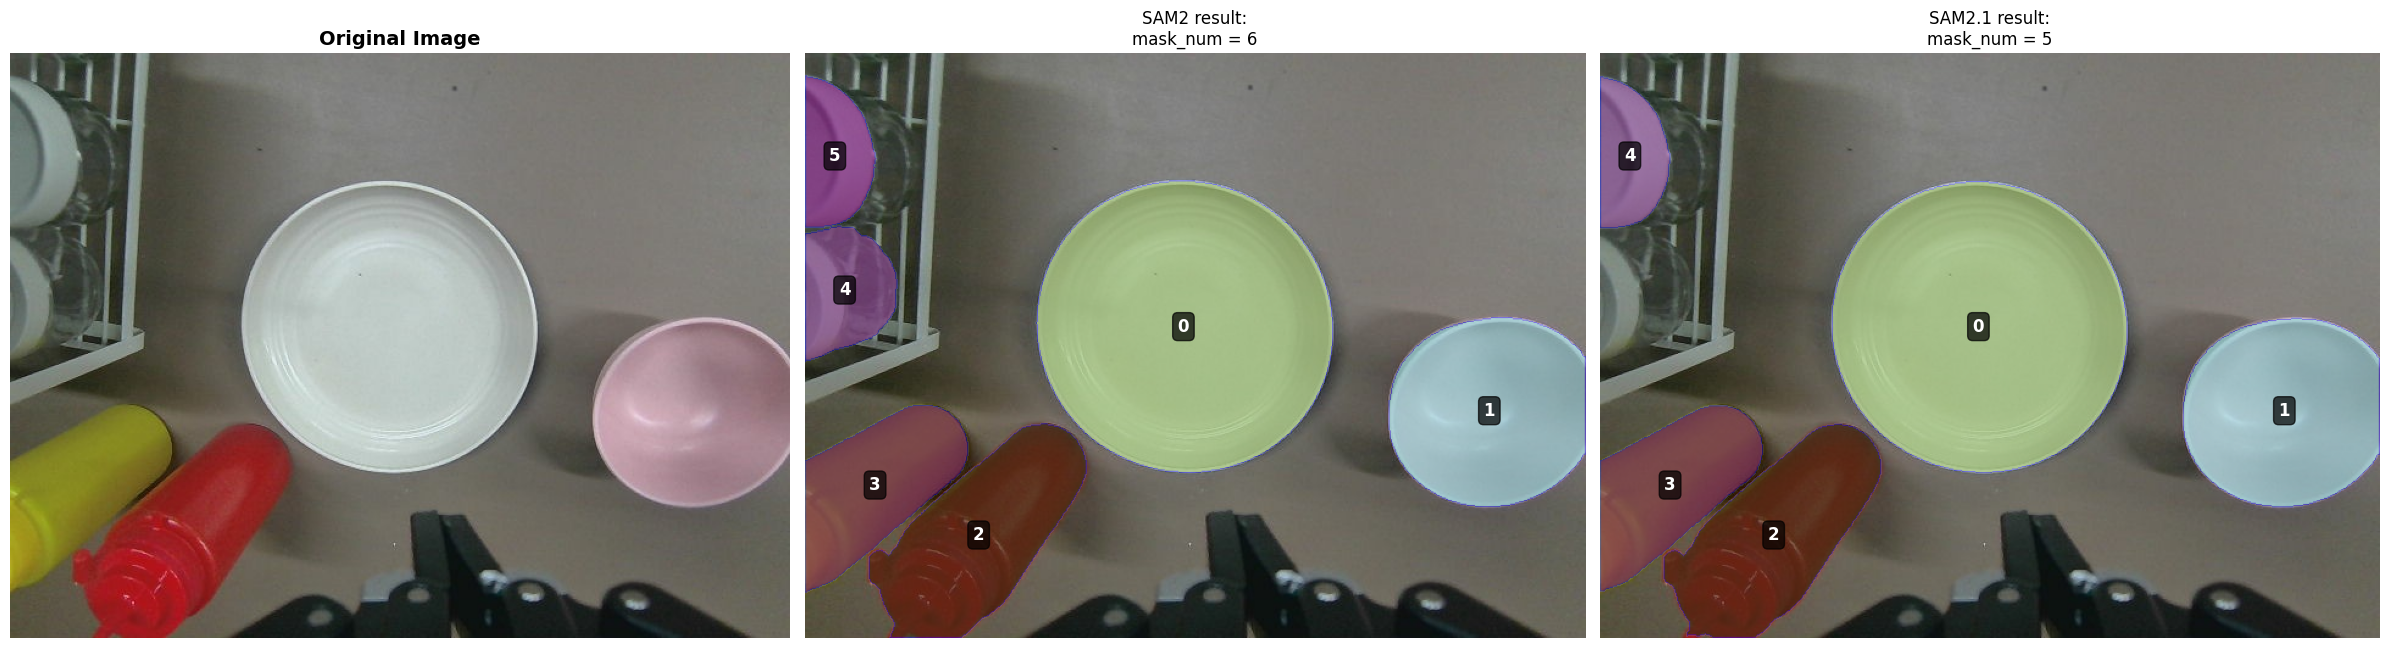


=== 分割结果对比 ===
SAM2 检测到的掩码数量: 6
SAM2.1 检测到的掩码数量: 5

SAM2 掩码面积统计:
  平均面积: 18108.0 像素
  最大面积: 45956 像素
  最小面积: 5719 像素

SAM2.1 掩码面积统计:
  平均面积: 20356.0 像素
  最大面积: 45866 像素
  最小面积: 5708 像素


In [77]:
masks_sam2, masks_sam2_1 = comparator.compare_models('./img/test2.png')

处理图像 1/1: ./img/test1.png



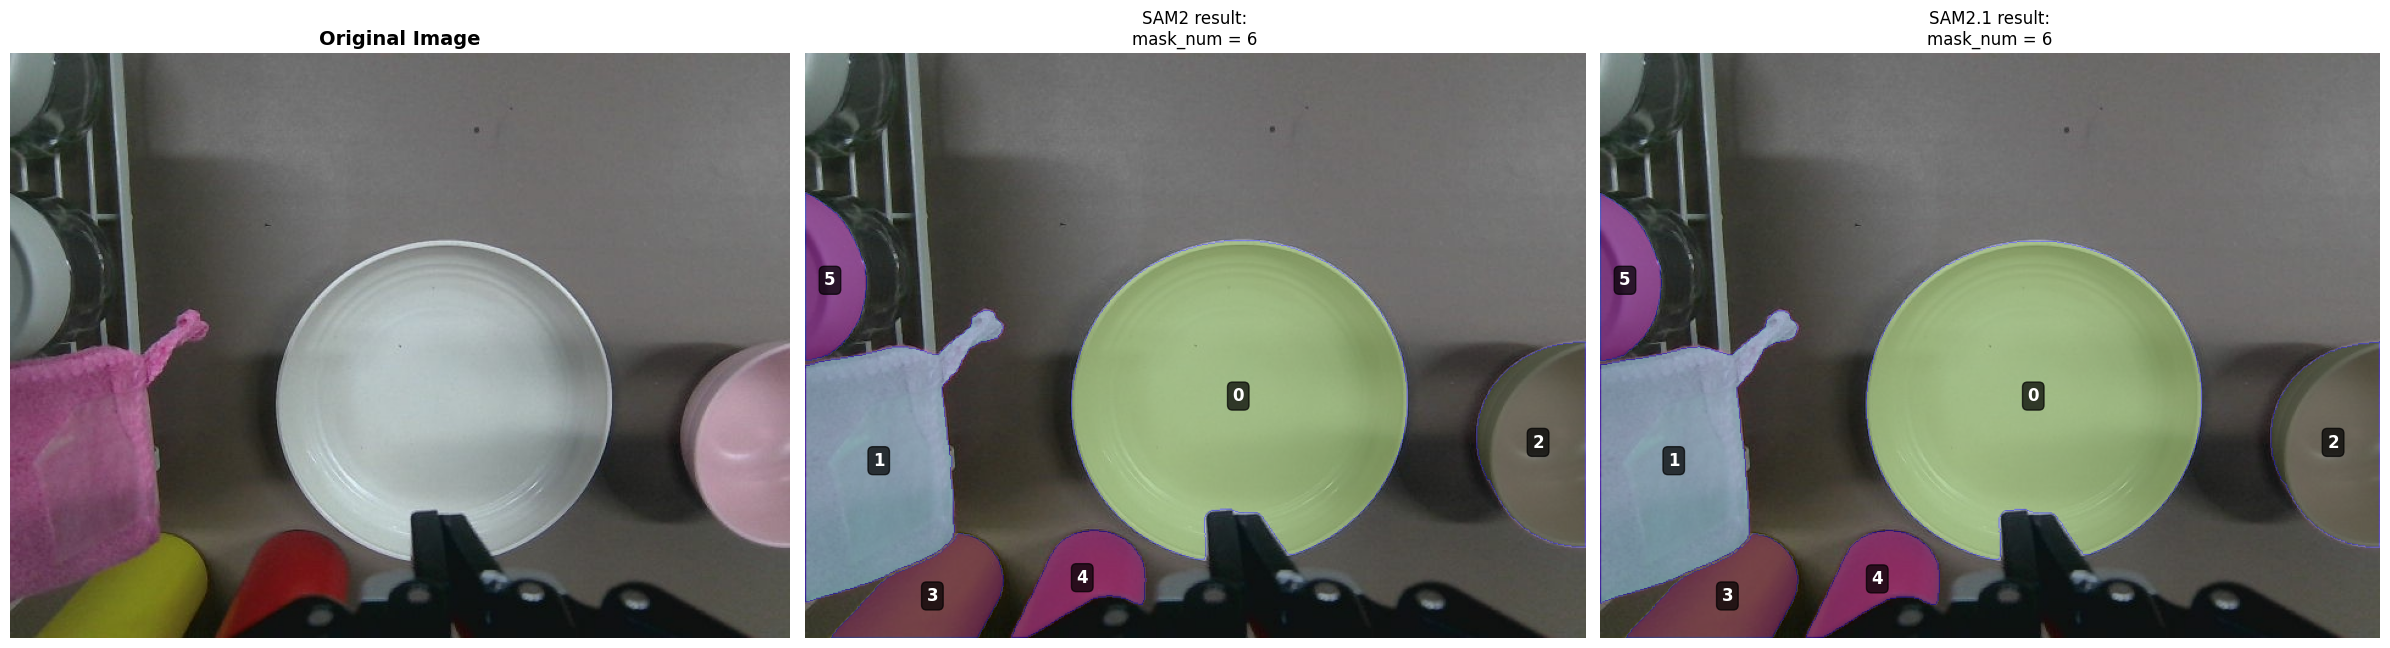


=== 分割结果对比 ===
SAM2 检测到的掩码数量: 6
SAM2.1 检测到的掩码数量: 6

SAM2 掩码面积统计:
  平均面积: 18026.0 像素
  最大面积: 55418 像素
  最小面积: 5211 像素

SAM2.1 掩码面积统计:
  平均面积: 18031.2 像素
  最大面积: 55435 像素
  最小面积: 5197 像素


In [78]:
image_list = [
    './img/test1.png',
    # './img/anon.jpg',
    # './img/dog.jpeg'
]

# 批量对比
comparator.batch_compare(image_list)